In [1]:
import mysql.connector as mydbconnection
from mysql.connector import Error
import re
import pandas as pd
import matplotlib.pyplot as plt
import json
import requests


conn = mydbconnection.connect(user='root',password='password')
cursor = conn.cursor()
cursor.execute("CREATE DATABASE `creditcard_capstone`")

In [4]:
#IMPORT SPARK AND INITIATE SPARK SESSIONS

import pyspark
import random
from pyspark.sql import SparkSession
from pyspark.sql.functions import lpad
spark = SparkSession.builder.appName('CAPSTONE').getOrCreate()

#IMPORT SPARKSQL FUNCTIONS
from pyspark.sql.functions import concat_ws
from pyspark.sql.functions import concat
from pyspark.sql.functions import initcap
from pyspark.sql.functions import lower
from pyspark.sql.functions import lit, rand

#to get all possible correct area codes for the mobile number
AREA_CODE_LIST = [i for i in range(201,990)] #area codes start from 201 and go to 989
for j in (211,311,411,511,611,711,811,911): #these numbers are not valid area codes
    AREA_CODE_LIST.remove(j)


CUSTOMER_DF = spark.read.json("cdw_sapp_custmer.json")
CUSTOMER_DF = CUSTOMER_DF.withColumn("FIRST_NAME", initcap(CUSTOMER_DF["FIRST_NAME"]))
CUSTOMER_DF = CUSTOMER_DF.withColumn("MIDDLE_NAME", lower(CUSTOMER_DF["MIDDLE_NAME"]))
CUSTOMER_DF = CUSTOMER_DF.withColumn("LAST_NAME", initcap(CUSTOMER_DF["LAST_NAME"]))
CUSTOMER_DF = CUSTOMER_DF.withColumn("FULL_STREET_ADDRESS", concat_ws(",", CUSTOMER_DF["APT_NO"], CUSTOMER_DF["STREET_NAME"]))
CUSTOMER_DF = CUSTOMER_DF.withColumn("AREA_CODE",lit(random.choice(AREA_CODE_LIST)))
CUSTOMER_DF = CUSTOMER_DF.withColumn("AREA_CODE", concat(lit("("),CUSTOMER_DF['AREA_CODE'],lit(")")))
CUSTOMER_DF = CUSTOMER_DF.withColumn("CUST_PHONE",concat(CUSTOMER_DF["CUST_PHONE"].substr(1,3),lit("-"),CUSTOMER_DF["CUST_PHONE"].substr(4,7)))
CUSTOMER_DF.createOrReplaceTempView("CUSTOMERDF")
CUSTOMER_DF = spark.sql('SELECT SSN, FIRST_NAME, MIDDLE_NAME, LAST_NAME, CREDIT_CARD_NO AS Credit_card_no, FULL_STREET_ADDRESS, CUST_CITY, CUST_STATE, CUST_COUNTRY, CONCAT(AREA_CODE, CUST_PHONE) AS CUST_PHONE, CUST_ZIP, CUST_EMAIL, LAST_UPDATED FROM CUSTOMERDF')

In [5]:
CUSTOMER_DF.write.format("jdbc") \
  .mode("append") \
  .option("url", "jdbc:mysql://localhost:3306/classicmodels") \
  .option("dbtable", "creditcard_capstone.CDW_SAPP_CUSTOMER") \
  .option("user", "root") \
  .option("password", "password") \
  .save()

In [6]:
BRANCH_DF = spark.read.json("cdw_sapp_branch.json")
BRANCH_DF = BRANCH_DF.withColumn("BRANCH_CODE", BRANCH_DF["BRANCH_CODE"])
BRANCH_DF = BRANCH_DF.withColumn("BRANCH_NAME", BRANCH_DF['BRANCH_NAME'])
BRANCH_DF = BRANCH_DF.withColumn("BRANCH_STREET", BRANCH_DF['BRANCH_STREET'])
BRANCH_DF = BRANCH_DF.withColumn("BRANCH_CITY", BRANCH_DF['BRANCH_CITY'])
BRANCH_DF = BRANCH_DF.withColumn("BRANCH_STATE", BRANCH_DF['BRANCH_STATE'])
BRANCH_DF = BRANCH_DF.withColumn("BRANCH_ZIP", BRANCH_DF['BRANCH_ZIP'])
BRANCH_DF = BRANCH_DF.fillna(99999,subset = ['BRANCH_ZIP']) #to fill null values with 99999 in the branch_zip column
BRANCH_DF = BRANCH_DF.withColumn("BRANCH_PHONE", concat(lit("("),BRANCH_DF['BRANCH_PHONE'].substr(1,3),lit(")"),BRANCH_DF['BRANCH_PHONE'].substr(4,3),lit("-"),BRANCH_DF['BRANCH_PHONE'].substr(7,4)))
BRANCH_DF = BRANCH_DF.withColumn("LAST_UPDATED", BRANCH_DF['LAST_UPDATED'])
BRANCH_DF.createOrReplaceTempView("BRANCHDF")
BRANCH_DF = spark.sql('SELECT BRANCH_CODE, BRANCH_NAME, BRANCH_STREET, BRANCH_CITY, BRANCH_STATE, BRANCH_ZIP, BRANCH_PHONE, LAST_UPDATED FROM BRANCHDF')

In [7]:
BRANCH_DF.write.format("jdbc") \
  .mode("append") \
  .option("url", "jdbc:mysql://localhost:3306/classicmodels") \
  .option("dbtable", "creditcard_capstone.CDW_SAPP_BRANCH") \
  .option("user", "root") \
  .option("password", "password") \
  .save()

In [8]:

CREDIT_DF = spark.read.json("cdw_sapp_credit.json")
CREDIT_DF = CREDIT_DF.withColumn("CUST_CC_NO", CREDIT_DF["CREDIT_CARD_NO"])
CREDIT_DF = CREDIT_DF.withColumn("DAY", CREDIT_DF['DAY'])
CREDIT_DF = CREDIT_DF.withColumn("MONTH", CREDIT_DF['MONTH'])
CREDIT_DF = CREDIT_DF.withColumn("YEAR", CREDIT_DF['YEAR'])
CREDIT_DF = CREDIT_DF.withColumn("TIMEID", concat(CREDIT_DF['YEAR'], lpad(CREDIT_DF['MONTH'],2,"0"), lpad(CREDIT_DF['DAY'],2,"0")))
CREDIT_DF = CREDIT_DF.withColumn("CUST_SSN", CREDIT_DF['CUST_SSN'])
CREDIT_DF = CREDIT_DF.withColumn("BRANCH_CODE", CREDIT_DF['BRANCH_CODE'])
CREDIT_DF = CREDIT_DF.withColumn("TRANSACTION_TYPE", CREDIT_DF['TRANSACTION_TYPE'])
CREDIT_DF = CREDIT_DF.withColumn("TRANSACTION_VALUE", CREDIT_DF['TRANSACTION_VALUE'])
CREDIT_DF = CREDIT_DF.withColumn("TRANSACTION_ID", CREDIT_DF['TRANSACTION_ID'])
CREDIT_DF.createOrReplaceTempView("CREDITDF")
CREDIT_DF = spark.sql('SELECT CUST_CC_NO, TIMEID, CUST_SSN, BRANCH_CODE, TRANSACTION_TYPE, TRANSACTION_VALUE, TRANSACTION_ID FROM CREDITDF')

In [9]:
CREDIT_DF.write.format("jdbc") \
  .mode("append") \
  .option("url", "jdbc:mysql://localhost:3306/classicmodels") \
  .option("dbtable", "creditcard_capstone.CDW_SAPP_CREDIT_CARD") \
  .option("user", "root") \
  .option("password", "password") \
  .save()

In [10]:
def transactions_by_zip_month_year():
    while True:
        try:
            conn = mydbconnection.connect(database='creditcard_capstone', user='root', password='password', port=3306)
            cursor = conn.cursor()

            zipcode = input("Enter the ZIP code: ")
            if len(zipcode) != 5 or not zipcode.isnumeric():
                print("Please enter a valid 5-digit zipcode")
                continue
            month = input("Enter the month: ")
            month = month.zfill(2)
            if int(month) < 1 or int(month) > 12 or not month.isnumeric():
                print("Please enter a valid month number (1-12)")
                continue
            year = input("Enter the year: ")
            if int(year) < 1950 or int(year) > 2023 or not year.isnumeric():
                print("Please enter a valid year (1950-2023)")
                continue

            transactions_by_zip_month_year_query = f"""SELECT SUBSTRING(CDW_SAPP_CREDIT_CARD.TIMEID, 7, 2), CDW_SAPP_CREDIT_CARD.TRANSACTION_ID, CDW_SAPP_CREDIT_CARD.TRANSACTION_TYPE, CONCAT('$', CDW_SAPP_CREDIT_CARD.TRANSACTION_VALUE) FROM CDW_SAPP_CREDIT_CARD JOIN CDW_SAPP_CUSTOMER ON CDW_SAPP_CREDIT_CARD.CUST_SSN = CDW_SAPP_CUSTOMER.SSN WHERE CDW_SAPP_CUSTOMER.CUST_ZIP = '{zipcode}' AND SUBSTRING(CDW_SAPP_CREDIT_CARD.TIMEID, 5, 2) = '{month}' AND SUBSTRING(CDW_SAPP_CREDIT_CARD.TIMEID, 1, 4) = '{year}' ORDER BY SUBSTRING(CDW_SAPP_CREDIT_CARD.TIMEID, 7, 2) DESC;"""
            cursor.execute(transactions_by_zip_month_year_query)
            transactions_by_zip_month_year_result = cursor.fetchall()
            if len(transactions_by_zip_month_year_result) == 0:
                print("No transaction details found for the above zip code, month and year")
            for row in transactions_by_zip_month_year_result:
                transaction_day = row[0]
                transaction_id = row[1]
                transaction_type = row[2]
                transaction_value = row[3]
                print(f"TRANSACTION DAY: {transaction_day}, TRANSACTION ID: {transaction_id}, TRANSACTION TYPE: {transaction_type}, TRANSACTION VALUE : {transaction_value}")
            break

        except Error as e:
            print(f"""Error: '{e}'""")
        finally:
            cursor.close()
            conn.close()

if __name__ == "__main__":
    transactions_by_zip_month_year()

TRANSACTION DAY: 27, TRANSACTION ID: 2209, TRANSACTION TYPE: Entertainment, TRANSACTION VALUE : $51.92
TRANSACTION DAY: 27, TRANSACTION ID: 2219, TRANSACTION TYPE: Test, TRANSACTION VALUE : $44.03
TRANSACTION DAY: 25, TRANSACTION ID: 15269, TRANSACTION TYPE: Gas, TRANSACTION VALUE : $60.04
TRANSACTION DAY: 23, TRANSACTION ID: 23018, TRANSACTION TYPE: Healthcare, TRANSACTION VALUE : $63.88
TRANSACTION DAY: 23, TRANSACTION ID: 15838, TRANSACTION TYPE: Entertainment, TRANSACTION VALUE : $69.54
TRANSACTION DAY: 23, TRANSACTION ID: 20551, TRANSACTION TYPE: Education, TRANSACTION VALUE : $41.18
TRANSACTION DAY: 23, TRANSACTION ID: 20556, TRANSACTION TYPE: Gas, TRANSACTION VALUE : $90.58
TRANSACTION DAY: 22, TRANSACTION ID: 15238, TRANSACTION TYPE: Education, TRANSACTION VALUE : $44.25
TRANSACTION DAY: 21, TRANSACTION ID: 2193, TRANSACTION TYPE: Education, TRANSACTION VALUE : $65.17
TRANSACTION DAY: 20, TRANSACTION ID: 12646, TRANSACTION TYPE: Gas, TRANSACTION VALUE : $20.46
TRANSACTION DAY: 

In [11]:
def transactions_by_type():
    while True:
        try:
            conn = mydbconnection.connect(database='creditcard_capstone', user='root', password='password', port=3306)
            cursor = conn.cursor()

            category = input("Enter a category from the following : Entertainment, Bills, Healthcare, Education, Gas, Test, Grocery")
            category = category.capitalize()
            if category not in ['Entertainment', 'Bills', 'Healthcare', 'Education', 'Gas', 'Test', 'Grocery']:
                print("Please enter a valid category.")
                continue

            transactions_by_type_query = f"""SELECT CDW_SAPP_CREDIT_CARD.TRANSACTION_TYPE, COUNT(CDW_SAPP_CREDIT_CARD.TRANSACTION_TYPE), CONCAT('$', ROUND(SUM(CDW_SAPP_CREDIT_CARD.TRANSACTION_VALUE), 2)) FROM CDW_SAPP_CREDIT_CARD WHERE CDW_SAPP_CREDIT_CARD.TRANSACTION_TYPE = '{category}';"""

            cursor.execute(transactions_by_type_query)
            transactions_by_type_result = cursor.fetchall()
            
            for row in transactions_by_type_result:
                transaction_category = row[0]
                transaction_count = row[1]
                transaction_sum = row[2]

                print(f"CATEGORY: {transaction_category}, NUMBER OF TRANSACTIONS: {transaction_count}, TRANSACTION SUM: {transaction_sum}")

            break
        
        except Error as e:
            print(f"""Error: '{e}'""")
        finally:
            cursor.close()
            conn.close()

if __name__ == "__main__":
    transactions_by_type()

CATEGORY: Bills, NUMBER OF TRANSACTIONS: 6861, TRANSACTION SUM: $351405.28


In [12]:
state_abbreviation_to_name_dictionary = {'AL': 'Alabama','AK': 'Alaska','AZ': 'Arizona','AR': 'Arkansas','CA': 'California','CO': 'Colorado','CT': 'Connecticut','DE': 'Delaware','FL': 'Florida','GA': 'Georgia','HI': 'Hawaii','ID': 'Idaho','IL': 'Illinois','IN': 'Indiana','IA': 'Iowa','KS': 'Kansas','KY': 'Kentucky','LA': 'Louisiana','ME': 'Maine','MD': 'Maryland','MA': 'Massachusetts','MI': 'Michigan','MN': 'Minnesota','MS': 'Mississippi','MO': 'Missouri','MT': 'Montana','NE': 'Nebraska','NV': 'Nevada','NH': 'New Hampshire','NJ': 'New Jersey','NM': 'New Mexico','NY': 'New York','NC': 'North Carolina','ND': 'North Dakota','OH': 'Ohio','OK': 'Oklahoma','OR': 'Oregon','PA': 'Pennsylvania','RI': 'Rhode Island','SC': 'South Carolina','SD': 'South Dakota','TN': 'Tennessee','TX': 'Texas','UT': 'Utah','VT': 'Vermont','VA': 'Virginia','WA': 'Washington','WV': 'West Virginia','WI': 'Wisconsin','WY': 'Wyoming'}
def transactions_by_branch():
    while True:
        try:
            conn = mydbconnection.connect(database='creditcard_capstone', user='root', password='password', port=3306)
            cursor = conn.cursor()
            state = input("Please enter a state abbreviation: ")
            if state.upper() not in ['AL','AK', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA', 'HI', 'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'MD', 'MN', 'ME', 'MA', 'MI', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 'NM', 'NY', 'NC', 'ND', 'SD', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'TX', 'TN', 'UT', 'VT', 'VA', 'WA', 'WY', 'WI', 'WV']:
                print("Please enter a valid state abbreviation : ")
                continue
            transactions_by_branch_query = f"""SELECT CDW_SAPP_BRANCH.BRANCH_STATE, COUNT(CDW_SAPP_CREDIT_CARD.TRANSACTION_VALUE), CONCAT('$', ROUND(SUM(CDW_SAPP_CREDIT_CARD.TRANSACTION_VALUE), 2)) FROM CDW_SAPP_CREDIT_CARD JOIN CDW_SAPP_BRANCH ON CDW_SAPP_CREDIT_CARD.BRANCH_CODE = CDW_SAPP_BRANCH.BRANCH_CODE WHERE CDW_SAPP_BRANCH.BRANCH_STATE = '{state}';"""
            cursor.execute(transactions_by_branch_query)
            transactions_by_branch_result = cursor.fetchall()
            for row in transactions_by_branch_result:
                branch_state = row[0]
                branch_transaction_count = row[1]
                branch_transaction_sum = row[2]
                print(f"STATE: {state_abbreviation_to_name_dictionary[branch_state]}, NUMBER OF TRANSACTIONS: {branch_transaction_count}, TRANSACTION SUM: {branch_transaction_sum}")
            break

        except Error as e:
            print(f"""Error: '{e}'""")
        finally:
            cursor.close()
            conn.close()

if __name__ == "__main__":
    transactions_by_branch()

STATE: Minnesota, NUMBER OF TRANSACTIONS: 1127, TRANSACTION SUM: $56153.29


In [13]:
def customer_details():
    while True:
        try:
            conn = mydbconnection.connect(database='creditcard_capstone', user='root', password='password', port=3306)
            cursor = conn.cursor()
            customer_checker = input("You can choose to search for a customer using their card number or their social security number. Enter CCN to search by card number or SSN to search by SSN")
            
            if str(customer_checker).upper() == 'CCN':
                card_number = input("Please enter your credit card number")
                if len(card_number) != 16 or not card_number.isnumeric():
                    print("Please enter a valid 16 digit card number")
                    continue
                customer_details_query = f"""SELECT * FROM CDW_SAPP_CUSTOMER WHERE CDW_SAPP_CUSTOMER.Credit_card_no = '{card_number}';"""
                cursor.execute(customer_details_query)
                customer_details_result = cursor.fetchall()
                if len( customer_details_result) == 0:
                    print("No transaction details found for the above credit card number")
                
                for row in customer_details_result:
                    cust_ssn = row[0]
                    cust_first_name = row[1]
                    cust_middle_name = row[2]
                    cust_last_name = row[3]
                    cust_credit_card_no = row[4]
                    cust_address = row[5]
                    cust_city = row[6]
                    cust_state = row[7]
                    cust_country = row[8]
                    cust_phone = row[9]
                    cust_zip = row[10]
                    cust_email = row[11]
                    cust_last_updated = row[12]
                    print(f"SSN: {cust_ssn}, FIRST NAME: {cust_first_name}, MIDDLE NAME: {cust_middle_name}, LAST NAME: {cust_last_name}, CREDIT CARD NUMBER: {cust_credit_card_no}, ADDRESS: {cust_address}, CITY: {cust_city}, STATE: {cust_state}, COUNTRY: {cust_country}, PHONE: {cust_phone}, ZIP: {cust_zip}, EMAIL: {cust_email}, LAST UPDATED: {cust_last_updated}")
                    

            elif str(customer_checker).upper() == 'SSN':
                ssn_number = input("Please enter your Social Security Number")
                if len(ssn_number) != 9 or not ssn_number.isnumeric():
                    print("Please enter a valid 9 digit Social Security Number")
                    continue
                transactions_query = f"""SELECT * FROM CDW_SAPP_CUSTOMER WHERE CDW_SAPP_CUSTOMER.SSN = '{ssn_number}';"""
                cursor.execute(transactions_query)
                customer_detail_results = cursor.fetchall()
                if len(customer_detail_results) == 0:
                    print("No transaction details found for the above Social Security Number")
                for row in customer_detail_results:
                    cust_ssn = row[0]
                    cust_first_name = row[1]
                    cust_middle_name = row[2]
                    cust_last_name = row[3]
                    cust_credit_card_no = row[4]
                    cust_address = row[5]
                    cust_city = row[6]
                    cust_state = row[7]
                    cust_country = row[8]
                    cust_phone = row[9]
                    cust_zip = row[10]
                    cust_email = row[11]
                    cust_last_updated = row[12]
                    print(f"SSN: {cust_ssn}, FIRST NAME: {cust_first_name}, MIDDLE NAME: {cust_middle_name}, LAST NAME: {cust_last_name}, CREDIT CARD NUMBER: {cust_credit_card_no}, ADDRESS: {cust_address}, CITY: {cust_city}, STATE: {cust_state}, COUNTRY: {cust_country}, PHONE: {cust_phone}, ZIP: {cust_zip}, EMAIL: {cust_email}, LAST UPDATED: {cust_last_updated}")

            else:
                print("Invalid input")
            
            break
        except Error as e:
            print(f"""Error: '{e}'""")
        finally:
            cursor.close()
            conn.close()

if __name__ == "__main__":
    customer_details()

No transaction details found for the above Social Security Number


In [14]:
def update_details():
    while True:
        try:
            conn = mydbconnection.connect(database='creditcard_capstone', user='root', password='password', port=3306)
            cursor = conn.cursor()
            ssn = input("Use the customer whose records you want to update using their SSN. Remember, we will be updating information about this customer")
            
            if len(ssn) != 9 or not ssn.isnumeric():
                print("Please enter a valid 9 dight SSN")
                continue
            ufirst_name = input("Please enter the updated first name : ")
            umiddle_name = input("Please enter the updated middle name : ")
            ulast_name = input("Please enter the updated last name : ")
            ucc_no = input("Please enter the updated credit card number : ")
            uaddress = input("Please enter the updated address : ")
            ucity = input("Please enter the updated city : ")
            ustate = input("Please enter the updated state : ")
            ucountry = input("Please enter the updated country : ")
            uphone = input("Please enter the updated phone number : ")
            uzip = input("Please enter the updated zip : ")
            uemail = input("Please enter the updated email : ")
            update_details_query = f"""UPDATE CDW_SAPP_CUSTOMER SET CDW_SAPP_CUSTOMER.FIRST_NAME = '{ufirst_name}', CDW_SAPP_CUSTOMER.MIDDLE_NAME = '{umiddle_name}', CDW_SAPP_CUSTOMER.LAST_NAME = '{ulast_name}', CDW_SAPP_CUSTOMER.Credit_card_no = '{ucc_no}', CDW_SAPP_CUSTOMER.FULL_STREET_ADDRESS = '{uaddress}', CDW_SAPP_CUSTOMER.CUST_CITY = '{ucity}', CDW_SAPP_CUSTOMER.CUST_STATE = '{ustate}', CDW_SAPP_CUSTOMER.CUST_COUNTRY = '{ucountry}', CDW_SAPP_CUSTOMER.CUST_PHONE = '{uphone}', CDW_SAPP_CUSTOMER.CUST_ZIP = '{uzip}', CDW_SAPP_CUSTOMER.CUST_EMAIL = '{uemail}' WHERE CDW_SAPP_CUSTOMER.SSN = '{ssn}';"""
            cursor.execute(update_details_query)
            select_update_details_query = f"""SELECT * FROM CDW_SAPP_CUSTOMER WHERE CDW_SAPP_CUSTOMER.SSN = '{ssn}';"""
            cursor.execute(select_update_details_query)
            select_update_details_result = cursor.fetchall()
            for row in select_update_details_result:
                cust_ssn = row[0]
                cust_first_name = row[1]
                cust_middle_name = row[2]
                cust_last_name = row[3]
                cust_credit_card_no = row[4]
                cust_address = row[5]
                cust_city = row[6]
                cust_state = row[7]
                cust_country = row[8]
                cust_phone = row[9]
                cust_zip = row[10]
                cust_email = row[11]
                cust_last_updated = row[12]
                print(f"SSN: {cust_ssn}, FIRST NAME: {cust_first_name}, MIDDLE NAME: {cust_middle_name}, LAST NAME: {cust_last_name}, CREDIT CARD NUMBER: {cust_credit_card_no}, ADDRESS: {cust_address}, CITY: {cust_city}, STATE: {cust_state}, COUNTRY: {cust_country}, PHONE: {cust_phone}, ZIP: {cust_zip}, EMAIL: {cust_email}, LAST UPDATED: {cust_last_updated}")
                print("Data Updated Successfully")
            break
        except Error as e:
            print(f"""Error: '{e}'""")
        finally:
            cursor.close()
            conn.close()

if __name__ == "__main__":
    update_details()

In [15]:
month_number_to_name_dictionary = {'01': 'January','02': 'February','03': 'March','04': 'April','05': 'May','06': 'June','07': 'July','08': 'August','09': 'September','10': 'October','11': 'November','12': 'December'}
def monthly_bill():
    while True:
        try:
            conn = mydbconnection.connect(database='creditcard_capstone', user='root', password='password', port=3306)
            cursor = conn.cursor()
            card_number = input("Please enter your credit card number to generate a monthly bill for")
            if len(card_number) != 16 or not card_number.isnumeric():
                print("Please enter a valid 16 digit card number")
                continue
            month = input("Enter a month to generate a monthly bill for")
            if len(month) == 1:
                month = month.zfill(2)
            if int(month) < 1 or int(month) > 12 or not month.isnumeric():
                print("Please enter a valid month number (01-12)")
                continue
            year = input("Enter a year to generate a monthly bill for")
            if int(year) < 1950 or int(year) > 2023 or not year.isnumeric():
                print("Please enter a valid year (1950-2023)")
                continue
            monthly_bill_query = f"""SELECT CONCAT('$', ROUND(SUM(CDW_SAPP_CREDIT_CARD.TRANSACTION_VALUE), 2)) FROM CDW_SAPP_CREDIT_CARD WHERE SUBSTRING(CDW_SAPP_CREDIT_CARD.TIMEID, 5, 2) = '{month}' AND SUBSTRING(CDW_SAPP_CREDIT_CARD.TIMEID, 1, 4) = '{year}' AND CDW_SAPP_CREDIT_CARD.CUST_CC_NO = '{card_number}';"""
            cursor.execute(monthly_bill_query)
            monthly_bill_result = cursor.fetchall()
            for row in monthly_bill_result:
                bill_amount = row[0]
                print(f"BILL AMOUNT: {bill_amount} FOR THE MONTH OF {month_number_to_name_dictionary[month]} OF THE YEAR {year}")
            break

        except Error as e:
            print(f"""Error: '{e}'""")
        finally:
            cursor.close()
            conn.close()

if __name__ == "__main__":
    monthly_bill()

BILL AMOUNT: None FOR THE MONTH OF November OF THE YEAR 2018


In [16]:
def transaction_in_range():
    while True:
        try:
            conn = mydbconnection.connect(database='creditcard_capstone', user='root', password='password', port=3306)
            cursor = conn.cursor()
            card_number = input("Please enter your credit card number to find the transaction data of transactions made between two dates")
            if len(card_number) != 16 or not card_number.isnumeric():
                print("Please enter a valid 16 digit card number")
                continue

            start_date = input("Please enter the start date for the range in the format xxxx/xx/xx (YYYY/MM/DD)")
            end_date = input("Please enter the end date for the range in the format xxxx/xx/xx (YYYY/MM/DD)")
            
            
            date_pattern = r'^\d{4}/\d{2}/\d{2}$'
            if re.match(date_pattern, start_date):
                start_date_id = start_date.replace('/','')
            else:
                print("Invalid start date format. Please enter a date in the format 'xxxx/xx/xx'.")
                continue
            
            if re.match(date_pattern, end_date):
                end_date_id = end_date.replace('/','')
            else:
                print("Invalid end date format. Please enter a date in the format 'xxxx/xx/xx'.")

            transaction_in_range_query = f"""SELECT CONCAT(SUBSTRING(CDW_SAPP_CREDIT_CARD.TIMEID,1,4),'/', SUBSTRING(CDW_SAPP_CREDIT_CARD.TIMEID,5,2),'/', SUBSTRING(CDW_SAPP_CREDIT_CARD.TIMEID,7,2)),CDW_SAPP_CREDIT_CARD.TRANSACTION_ID, CDW_SAPP_CREDIT_CARD.TRANSACTION_TYPE, CONCAT('$', ROUND(CDW_SAPP_CREDIT_CARD.TRANSACTION_VALUE, 2)) FROM CDW_SAPP_CREDIT_CARD WHERE CDW_SAPP_CREDIT_CARD.TIMEID BETWEEN '{start_date_id}' AND '{end_date_id}' AND CDW_SAPP_CREDIT_CARD.CUST_CC_NO = '{card_number}' ORDER BY CDW_SAPP_CREDIT_CARD.TIMEID DESC;"""
            cursor.execute(transaction_in_range_query)
            transaction_in_range_result = cursor.fetchall()
            print(f"The transactions in the given date range : {start_date} - {end_date}")
            for row in transaction_in_range_result:
                transaction_timeid = row[0]
                transaction_id = row[1]
                transaction_type = row[2]
                transaction_value = row[3]
                print(f"DATE: {transaction_timeid}, TRANSACTION ID: {transaction_id}, TRANSACTION TYPE: {transaction_type}, TRANSACTION VALUE: {transaction_value}")
            break

        except Error as e:
            print(f"""Error: '{e}'""")
        finally:
            cursor.close()
            conn.close()

if __name__ == "__main__":
    transaction_in_range()

Invalid start date format. Please enter a date in the format 'xxxx/xx/xx'.
The transactions in the given date range : 2018/01/01 - 2018/02/02


In [1]:
def console_program():
    while True:
        user_input = input("Please enter T to see Transaction Data or C to see Customer Data")
        if user_input in ['t','T']:
            user_input1 = input("Enter 1 to display the transactions made by customers living in a given zip code for a given month and year ordered by day in descending order, 2 to display the number and total values of transactions for a given type or 3 to display the total number and total values of transactions for branches in a given state")


            if str(user_input1) == '1':
                transactions_by_zip_month_year()
            elif str(user_input1) == '2':
                transactions_by_type()
            elif str(user_input1) == '3':
                transactions_by_branch()
            else:
                print("Invalid input")

        elif user_input in ['c','C']:
            user_input2 = input("Enter 1 to check the existing account details of a customer, 2 to modify the existing account details of a customer, 3 to generate a monthly bill for a credit card number for a given month and year or 4 to display the transactions made by a customer between two dates ordered by year, month, and day in descending order")

            if str(user_input2) == '1':
                customer_details()
            elif str(user_input2) == '2':
                update_details()
            elif str(user_input2) == '3':
                monthly_bill()
            elif str(user_input2) == '4':
                transaction_in_range()
        
if __name__ == "__main__":
    console_program()

Invalid input
Invalid input


KeyboardInterrupt: Interrupted by user

C:\Users\Learner_9ZH3Z191\AppData\Local\Temp\ipykernel_4920\1266627463.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  TRANSACTION_DF = pd.read_sql(transactions_query,conn)


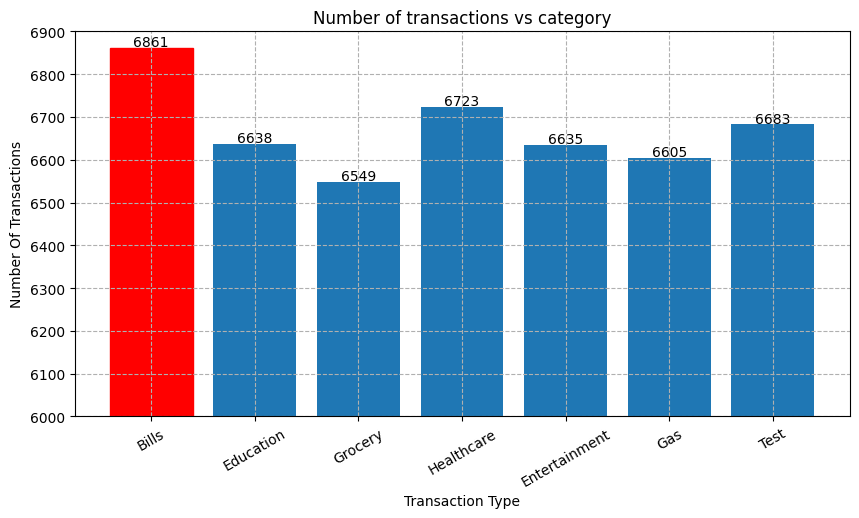

In [ ]:
conn = mydbconnection.connect(database='creditcard_capstone', user='root', password='password', port=3306)
transactions_query = "SELECT CDW_SAPP_CREDIT_CARD.TRANSACTION_TYPE AS `TRANSACTION TYPE`, COUNT(CDW_SAPP_CREDIT_CARD.TRANSACTION_ID) AS `TRANSACTION COUNT` FROM CDW_SAPP_CREDIT_CARD GROUP BY CDW_SAPP_CREDIT_CARD.TRANSACTION_TYPE;"
TRANSACTION_DF = pd.read_sql(transactions_query,conn)

X = TRANSACTION_DF['TRANSACTION TYPE']
Y = TRANSACTION_DF['TRANSACTION COUNT']
plt.figure(figsize=(10, 5))
ax = plt.axes()
plt.bar(X,Y)
bars = plt.gca().patches
for bar in bars:
    if bar.get_height() == max(TRANSACTION_DF['TRANSACTION COUNT']):
        bar.set_color('red')
for bar in bars:
    plt.annotate(f'{bar.get_height()}', xy=(bar.get_x() + bar.get_width()/2, bar.get_height()), xytext=(0, 4), textcoords="offset points", ha='center', va='center')
plt.xlabel("Transaction Type")
plt.ylabel("Number Of Transactions")
plt.xticks(rotation = 30)
plt.yticks([6000,6100,6200,6300,6400,6500,6600,6700,6800,6900])
plt.ylim(6000,6900)
plt.title("Number of transactions vs category")

ax.yaxis.grid(True, linestyle = '--')
ax.xaxis.grid(True, linestyle = '--')

C:\Users\Learner_9ZH3Z191\AppData\Local\Temp\ipykernel_21468\179842157.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  STATE_DF = pd.read_sql(transactions_query,conn)


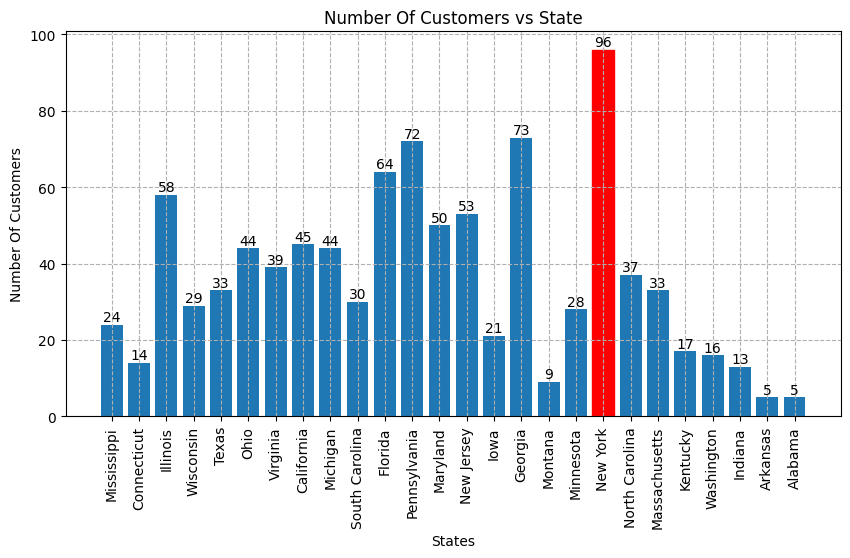

In [ ]:
conn = mydbconnection.connect(database='creditcard_capstone', user='root', password='password', port=3306)
transactions_query = "SELECT CDW_SAPP_CUSTOMER.CUST_STATE AS `STATE`, COUNT(CDW_SAPP_CUSTOMER.CUST_STATE) AS `NUMBER OF CUSTOMERS` FROM CDW_SAPP_CUSTOMER GROUP BY CDW_SAPP_CUSTOMER.CUST_STATE;"
STATE_DF = pd.read_sql(transactions_query,conn)
state_abbreviation_to_name_dictionary = {'AL': 'Alabama','AK': 'Alaska','AZ': 'Arizona','AR': 'Arkansas','CA': 'California','CO': 'Colorado','CT': 'Connecticut','DE': 'Delaware','FL': 'Florida','GA': 'Georgia','HI': 'Hawaii','ID': 'Idaho','IL': 'Illinois','IN': 'Indiana','IA': 'Iowa','KS': 'Kansas','KY': 'Kentucky','LA': 'Louisiana','ME': 'Maine','MD': 'Maryland','MA': 'Massachusetts','MI': 'Michigan','MN': 'Minnesota','MS': 'Mississippi','MO': 'Missouri','MT': 'Montana','NE': 'Nebraska','NV': 'Nevada','NH': 'New Hampshire','NJ': 'New Jersey','NM': 'New Mexico','NY': 'New York','NC': 'North Carolina','ND': 'North Dakota','OH': 'Ohio','OK': 'Oklahoma','OR': 'Oregon','PA': 'Pennsylvania','RI': 'Rhode Island','SC': 'South Carolina','SD': 'South Dakota','TN': 'Tennessee','TX': 'Texas','UT': 'Utah','VT': 'Vermont','VA': 'Virginia','WA': 'Washington','WV': 'West Virginia','WI': 'Wisconsin','WY': 'Wyoming'}
X = STATE_DF['STATE'].map(state_abbreviation_to_name_dictionary)
Y = STATE_DF['NUMBER OF CUSTOMERS']
plt.figure(figsize=(10, 5))
ax = plt.axes()
plt.bar(X,Y)
bars = plt.gca().patches

for bar in bars:
    if bar.get_height() == max(STATE_DF['NUMBER OF CUSTOMERS']):
        bar.set_color('red')
for bar in bars:
    plt.annotate(f'{bar.get_height()}', xy=(bar.get_x() + bar.get_width()/2, bar.get_height()), xytext=(0, 0.5), textcoords="offset points", ha='center', va='bottom')
plt.xlabel("States")
plt.ylabel("Number Of Customers")
plt.xticks(rotation=90)
plt.title("Number Of Customers vs State")
ax.xaxis.grid(True, linestyle = '--')
ax.yaxis.grid(True, linestyle = '--')


C:\Users\Learner_9ZH3Z191\AppData\Local\Temp\ipykernel_4920\3923503760.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  TOPTENT_DF = pd.read_sql(transactions_sum_query,conn)
C:\Users\Learner_9ZH3Z191\AppData\Local\Temp\ipykernel_4920\3923503760.py:5: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  TOPTENN_DF = pd.read_sql(name_query,conn)


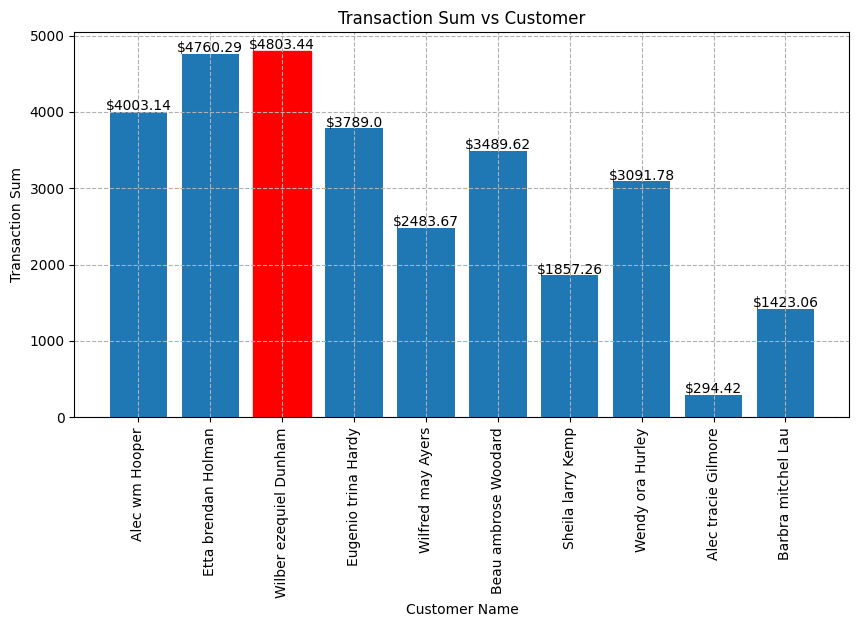

In [ ]:
conn = mydbconnection.connect(database='creditcard_capstone', user='root', password='password', port=3306)
transactions_sum_query = "SELECT ROUND(SUM(CDW_SAPP_CREDIT_CARD.TRANSACTION_VALUE),2) AS `TRANSACTION SUM` FROM CDW_SAPP_CREDIT_CARD JOIN CDW_SAPP_CUSTOMER ON CDW_SAPP_CREDIT_CARD.CUST_SSN = CDW_SAPP_CUSTOMER.SSN GROUP BY CDW_SAPP_CUSTOMER.SSN LIMIT 10;"
name_query = "SELECT CONCAT(CDW_SAPP_CUSTOMER.FIRST_NAME,' ',CDW_SAPP_CUSTOMER.MIDDLE_NAME,' ',CDW_SAPP_CUSTOMER.LAST_NAME) AS `CUSTOMER NAME` FROM CDW_SAPP_CUSTOMER LIMIT 10"
TOPTENT_DF = pd.read_sql(transactions_sum_query,conn)
TOPTENN_DF = pd.read_sql(name_query,conn)
X = TOPTENN_DF['CUSTOMER NAME']
Y = TOPTENT_DF['TRANSACTION SUM']

plt.figure(figsize=(10, 5))
ax = plt.axes()
plt.bar(X,Y)
bars = plt.gca().patches
for bar in bars:
    if bar.get_height() == max(TOPTENT_DF['TRANSACTION SUM']):
        bar.set_color('red')
for bar in bars:
    plt.annotate(f'${bar.get_height()}', xy=(bar.get_x() + bar.get_width()/2, bar.get_height()), xytext=(0, 4), textcoords="offset points", ha='center', va='center')
plt.xlabel("Customer Name")
plt.ylabel("Transaction Sum")
plt.xticks(rotation = 90)
plt.title("Transaction Sum vs Customer")

ax.yaxis.grid(True, linestyle = '--')
ax.xaxis.grid(True, linestyle = '--')

In [ ]:
url = 'https://raw.githubusercontent.com/platformps/LoanDataset/main/loan_data.json'
response = requests.get(url)
loan_data = response.json()
print(f"The status code for the above API response : {response.status_code}")

LOAN_DF = spark.read.json("raw.githubusercontent.com_platformps_LoanDataset_main_loan_data.json")
LOAN_DF.write.format("jdbc") \
  .mode("append") \
  .option("url", "jdbc:mysql://localhost:3306/classicmodels") \
  .option("dbtable", "creditcard_capstone.CDW_SAPP_loan_application") \
  .option("user", "root") \
  .option("password", "password") \
  .save()

The status code for the above API response : 200


In [ ]:
conn = mydbconnection.connect(database='creditcard_capstone', user='root', password='password', port=3306)
self_employed_approved_query = 'SELECT COUNT(CDW_SAPP_loan_application.Application_Status) AS `APPROVED SELF EMPLOYED` FROM CDW_SAPP_loan_application WHERE CDW_SAPP_loan_application.Application_Status = "Y" AND CDW_SAPP_loan_application.Self_Employed = "Yes";'
self_employed_query = 'SELECT COUNT(CDW_SAPP_loan_application.Self_Employed) AS `TOTAL SELF EMPLOYED` FROM CDW_SAPP_loan_application WHERE CDW_SAPP_loan_application.Self_Employed = "Yes";'
SELF_EMPLOYED_APPROVED_DF = pd.read_sql(self_employed_approved_query,conn)
SELF_EMPLOYED_DF = pd.read_sql(self_employed_query,conn)

approved = SELF_EMPLOYED_APPROVED_DF['APPROVED SELF EMPLOYED'][0]
not_approved = SELF_EMPLOYED_DF['TOTAL SELF EMPLOYED'][0] - SELF_EMPLOYED_APPROVED_DF['APPROVED SELF EMPLOYED'][0]

plt.figure(figsize=(10, 7))
plt.pie([approved, not_approved], labels=["Approved","Not Approved"], autopct='%1.2f%%', startangle=180, colors=['teal','orange'])
plt.title("Percentage Self Employed Approved for Loan")
plt.legend()
plt.show()

C:\Users\Learner_9ZH3Z191\AppData\Local\Temp\ipykernel_21468\3146411367.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  SELF_EMPLOYED_APPROVED_DF = pd.read_sql(self_employed_approved_query,conn)


DatabaseError: Execution failed on sql 'SELECT COUNT(CDW_SAPP_loan_application.Application_Status) AS `APPROVED SELF EMPLOYED` FROM CDW_SAPP_loan_application WHERE CDW_SAPP_loan_application.Application_Status = "Y" AND CDW_SAPP_loan_application.Self_Employed = "Yes";': 1146 (42S02): Table 'creditcard_capstone.cdw_sapp_loan_application' doesn't exist

C:\Users\Learner_9ZH3Z191\AppData\Local\Temp\ipykernel_2736\2124882120.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  REJECTED_MALE_DF = pd.read_sql(rejected_male_query,conn)
C:\Users\Learner_9ZH3Z191\AppData\Local\Temp\ipykernel_2736\2124882120.py:5: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  TOTAL_MALE_DF = pd.read_sql(total_male_query,conn)


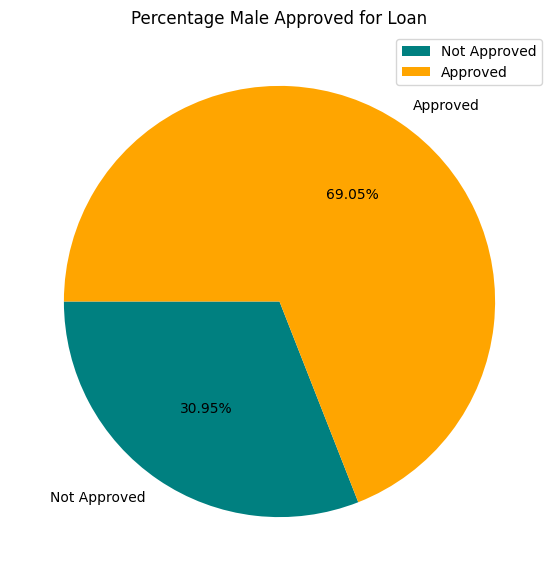

In [ ]:
conn = mydbconnection.connect(database='creditcard_capstone', user='root', password='password', port=3306)
rejected_male_query = 'SELECT COUNT(CDW_SAPP_loan_application.Application_Status) AS `REJECTED MALE` FROM CDW_SAPP_loan_application WHERE CDW_SAPP_loan_application.Application_Status = "N" AND CDW_SAPP_loan_application.Gender = "Male";'
total_male_query = 'SELECT COUNT(CDW_SAPP_loan_application.Gender) AS `TOTAL MALE` FROM CDW_SAPP_loan_application WHERE CDW_SAPP_loan_application.Gender = "Male";'
REJECTED_MALE_DF = pd.read_sql(rejected_male_query,conn)
TOTAL_MALE_DF = pd.read_sql(total_male_query,conn)

rejected_male = REJECTED_MALE_DF['REJECTED MALE'][0]
approved_male = TOTAL_MALE_DF['TOTAL MALE'][0] - REJECTED_MALE_DF['REJECTED MALE'][0]

plt.figure(figsize=(10, 7))
plt.pie([rejected_male, approved_male], labels=["Not Approved", "Approved"], autopct='%1.2f%%', startangle=180, colors=['teal','orange'])
plt.title("Percentage Male Approved for Loan")
plt.legend()

C:\Users\Learner_9ZH3Z191\AppData\Local\Temp\ipykernel_21468\2399074069.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  TRANSACTION_VOLUME_DF = pd.read_sql(transaction_volume_query,conn)


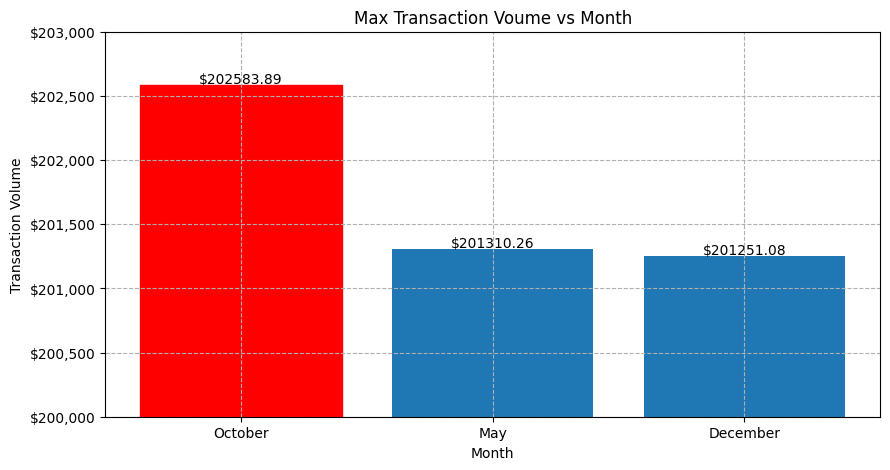

In [ ]:
conn = mydbconnection.connect(database='creditcard_capstone', user='root', password='password', port=3306)
transaction_volume_query = 'SELECT SUBSTRING(CDW_SAPP_CREDIT_CARD.TIMEID, 5, 2) AS MONTH, COUNT(CDW_SAPP_CREDIT_CARD.TRANSACTION_VALUE) AS `NUMBER OF TRANSACTIONS`, ROUND(SUM(CDW_SAPP_CREDIT_CARD.TRANSACTION_VALUE), 2) AS `TRANSACTION TOTAL` FROM CDW_SAPP_CREDIT_CARD GROUP BY SUBSTRING(CDW_SAPP_CREDIT_CARD.TIMEID, 5, 2) ORDER BY `TRANSACTION TOTAL` DESC LIMIT 3;'
TRANSACTION_VOLUME_DF = pd.read_sql(transaction_volume_query,conn)
month_number_to_name_dictionary = {'01': 'January','02': 'February','03': 'March','04': 'April','05': 'May','06': 'June','07': 'July','08': 'August','09': 'September','10': 'October','11': 'November','12': 'December'}
Y = TRANSACTION_VOLUME_DF['TRANSACTION TOTAL']
X = TRANSACTION_VOLUME_DF['MONTH'].map(month_number_to_name_dictionary)
plt.figure(figsize=(10, 5))
ax = plt.axes()
plt.bar(X,Y)
bars = plt.gca().patches
for bar in bars:
    if bar.get_height() == max(TRANSACTION_VOLUME_DF['TRANSACTION TOTAL']):
        bar.set_color('red')
for bar in bars:
    plt.annotate(f'${bar.get_height()}', xy=(bar.get_x() + bar.get_width()/2, bar.get_height()), xytext=(0, 4), textcoords="offset points", ha='center', va='center')
plt.xlabel("Month")
plt.ylabel("Transaction Volume")
plt.xticks()
plt.yticks([200000,200500,201000,201500,202000,202500,203000],['$200,000','$200,500','$201,000','$201,500','$202,000','$202,500','$203,000'])
plt.ylim(200000,203000)
plt.title("Max Transaction Voume vs Month")
ax.yaxis.grid(True, linestyle = '--')
ax.xaxis.grid(True, linestyle = '--')
plt.show()



C:\Users\Learner_9ZH3Z191\AppData\Local\Temp\ipykernel_19184\2425195846.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  HEALTHCARE_DF = pd.read_sql(healtcare_query,conn)


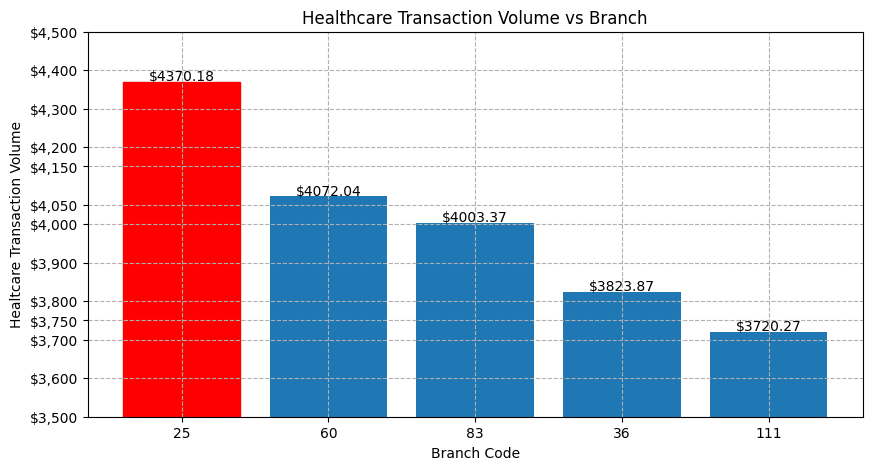

In [41]:
conn = mydbconnection.connect(database='creditcard_capstone', user='root', password='password', port=3306)
healtcare_query = 'SELECT CAST(CDW_SAPP_BRANCH.BRANCH_CODE AS CHAR(3)) AS `BRANCH CODE`, ROUND(SUM(CDW_SAPP_CREDIT_CARD.TRANSACTION_VALUE),2) AS `TRANSACTION TOTAL` FROM CDW_SAPP_CREDIT_CARD JOIN CDW_SAPP_BRANCH ON CDW_SAPP_CREDIT_CARD.BRANCH_CODE = CDW_SAPP_BRANCH.BRANCH_CODE WHERE CDW_SAPP_CREDIT_CARD.TRANSACTION_TYPE = "Healthcare" GROUP BY `BRANCH CODE` ORDER BY `TRANSACTION TOTAL` DESC LIMIT 5;'
HEALTHCARE_DF = pd.read_sql(healtcare_query,conn)
HEALTHCARE_DF
X = HEALTHCARE_DF['BRANCH CODE']
Y = HEALTHCARE_DF['TRANSACTION TOTAL']
plt.figure(figsize=(10, 5))
ax = plt.axes()
plt.bar(X,Y)
bars = plt.gca().patches
for bar in bars:
    if bar.get_height() == max(HEALTHCARE_DF['TRANSACTION TOTAL']):
        bar.set_color('red')
for bar in bars:
    plt.annotate(f'${bar.get_height()}', xy=(bar.get_x() + bar.get_width()/2, bar.get_height()), xytext=(0, 4), textcoords="offset points", ha='center', va='center')
plt.xlabel("Branch Code")
plt.ylabel("Healtcare Transaction Volume")
plt.yticks([3500,3600,3700,3750,3800,3900,4000,4050,4150,4200,4300,4400,4500],['$3,500','$3,600','$3,700','$3,750','$3,800','$3,900','$4,000','$4,050','$4,150','$4,200','$4,300','$4,400','$4,500'])
plt.ylim(3500,4500)
plt.title("Healthcare Transaction Volume vs Branch")

ax.yaxis.grid(True, linestyle = '--')
ax.xaxis.grid(True, linestyle = '--')

In [55]:
US_CITIES_DF = pd.read_csv("uscities.csv")
US_CITIES_DF


,city,city_ascii,state_id,state_name,county_fips,county_name,lat,lng,population,density,source,military,incorporated,timezone,ranking,zips,id
0,New York,New York,NY,New York,36081,Queens,40.6943,-73.9249,18972871,10768.2,shape,False,True,America/New_York,1,11229 11226 11225 11224 11223 11221 11220 1138...,1840034016
1,Los Angeles,Los Angeles,CA,California,6037,Los Angeles,34.1141,-118.4068,12121244,3267.6,shape,False,True,America/Los_Angeles,1,90291 90293 90292 91316 91311 90035 90034 9003...,1840020491
2,Chicago,Chicago,IL,Illinois,17031,Cook,41.8375,-87.6866,8595181,4576.6,shape,False,True,America/Chicago,1,60018 60649 60641 60640 60643 60642 60645 6064...,1840000494
3,Miami,Miami,FL,Florida,12086,Miami-Dade,25.7840,-80.2101,5711945,4945.7,shape,False,True,America/New_York,1,33128 33129 33125 33126 33127 33149 33144 3314...,1840015149
4,Dallas,Dallas,TX,Texas,48113,Dallas,32.7935,-96.7667,5668165,1522.2,shape,False,True,America/Chicago,1,75287 75098 75234 75254 75251 75252 75253 7503...,1840019440
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30839,Ironville,Ironville,PA,Pennsylvania,42013,Blair,40.6586,-78.2155,0,59.2,shape,False,False,America/New_York,3,16686,1840152922
30840,Newkirk,Newkirk,NM,New Mexico,35019,Guadalupe,35.0635,-104.2715,0,0.0,shape,False,False,America/Denver,3,88417,1840024978
30841,Falcon Village,Falcon Village,TX,Texas,48427,Starr,26.5652,-99.1341,0,38.9,shape,False,False,America/Chicago,3,78545,1840018314
30842,Hidden Lakes,Hidden Lakes,OH,Ohio,39117,Morrow,40.5479,-82.7632,0,18.6,shape,False,False,America/New_York,3,43338,1840153068


In [1]:
%pip install SQLAlchemy


  Obtaining dependency information for SQLAlchemy from https://files.pythonhosted.org/packages/99/d5/8293efd969f05cca8281b28d88a53c818903768e4339e1ca78897dbd242d/SQLAlchemy-2.0.22-cp310-cp310-win_amd64.whl.metadata
  Obtaining dependency information for greenlet!=0.4.17 from https://files.pythonhosted.org/packages/74/5a/a01c985b5d35c079eb33a5b0502c4cccb5ae1037ee67e2512222059617d1/greenlet-3.0.0-cp310-cp310-win_amd64.whl.metadata
   ---------------------------------------- 0.0/2.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.1 MB ? eta -:--:--
    --------------------------------------- 0.0/2.1 MB ? eta -:--:--
    --------------------------------------- 0.0/2.1 MB 495.5 kB/s eta 0:00:05
   - -------------------------------------- 0.1/2.1 MB 544.7 kB/s eta 0:00:04
   - -------------------------------------- 0.1/2.1 MB 491.5 kB/s eta 0:00:05
   -- ------------------------------------- 0.1/2.1 MB 5